# Derivation of the Statistical Dispersion Model for Optiland's AbbeMaterial - 2026 Update

Kramer Harrison, 2026

## 1. Introduction
In first-order optical design, materials are often defined solely by their refractive index ($n_d$) and Abbe number ($V_d$). While sufficient for paraxial achromatization, this two-parameter definition is mathematically under-determined: infinite dispersion curves can satisfy a single ($n_d, V_d$) pair.

Standard approximations, such as the "Normal Line" rule, assume a fixed linear relationship between partial dispersion ($P_{g,F}$) and Abbe number. While effective for standard crowns and flints, this heuristic fails for "anomalous" glasses (e.g., fluor-crowns or dense flints), leading to significant index prediction errors in the deep blue ($<0.45 \mu m$) and near-infrared.

### Objective
This study derives a robust, data-driven dispersion model to resolve this ambiguity. By analyzing refractive index data of over 1,000 commercial optical glasses, we aim to:

1.  **Determine Dimensionality:** Use Principal Component Analysis (PCA) to quantify the effective degrees of freedom in standard optical glasses.
2.  **Select a Basis:** Apply **LassoLarsIC** (Sparse Regression) to the Buchdahl dispersion formula to identify the minimum set of coefficients required for accurate spectral reconstruction.
3.  **Validate Stability:** Demonstrate that this sparse, physics-informed model minimizes spectral error compared to standard linear approximations.

In [1]:
import warnings
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoLarsIC, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.optimize import curve_fit
from optiland.materials import MaterialFile

In [2]:
# Configuration
CATALOG_PATH = '../../database/catalog_nk.csv'  # in Optiland's database dir
DATA_DIR = '../../database/data-nk/'  # in Optiland's database dir

# We filter for established manufacturers to ensure we are modeling 
# the physics of stable, amorphous silicate/phosphate glasses.
VALID_CATALOGS = [
    'schott', 'ohara', 'hoya', 'cdgm', 'sumita', 'hikari'
]

# Wavelength grid for analysis (Extended Visible: 0.38 - 0.78 µm)
WAVE_GRID = np.linspace(0.380, 0.780, 100)

In [3]:
# Define standard reference wavelengths for Abbe definition
# Helium d-line (yellow), Hydrogen F (blue), Hydrogen C (red)
WAVE_D = 0.5875618
WAVE_F = 0.4861327
WAVE_C = 0.6562725

def load_standard_glasses(catalog_path=CATALOG_PATH, wave_grid=WAVE_GRID):
    """
    Ingests the glass database and filters for physically standard optical glasses.
    Returns a DataFrame containing the 'Ground Truth' dispersion curves.
    """
    print(f"Loading glass database from {catalog_path}...")
    
    if not os.path.exists(catalog_path):
        raise FileNotFoundError(f"Catalog file not found at: {catalog_path}")

    df_raw = pd.read_csv(catalog_path)
    valid_data = []
    
    # Statistics for the log
    stats = {'total': len(df_raw), 'success': 0, 'range_skip': 0, 'error_skip': 0, 'manuf_skip': 0}
    
    # Standard glass range settings
    ND_MIN, ND_MAX = 1.35, 2.6
    VD_MIN, VD_MAX = 15.0, 100.0

    for idx, row in df_raw.iterrows():
        # 1. Manufacturer Check
        f_name = str(row.get('filename', '')).lower()
        g_name = str(row.get('group', '')).lower()
        identifier = f_name + g_name
        
        is_valid_catalog = any(c in identifier for c in VALID_CATALOGS)
        
        if not is_valid_catalog:
            stats['manuf_skip'] += 1
            continue

        filepath = os.path.join(DATA_DIR, row['filename'])
        if not os.path.exists(filepath):
            stats['error_skip'] += 1
            continue

        try:
            # 2. Load material
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                mat = MaterialFile(filepath)
                
                # Abbe Definitions
                nd = mat.n(WAVE_D).item()
                nF = mat.n(WAVE_F).item()
                nC = mat.n(WAVE_C).item()

            # 3. Physics & Range Sanity Checks
            if np.isnan(nd) or nd <= 1.0:
                stats['error_skip'] += 1
                continue

            dispersion = nF - nC
            if dispersion <= 1e-9:
                stats['error_skip'] += 1
                continue
            
            Vd = (nd - 1) / dispersion

            # Filter out extreme materials
            if not (ND_MIN < nd < ND_MAX):
                stats['range_skip'] += 1
                continue
            
            if not (VD_MIN < Vd < VD_MAX):
                stats['range_skip'] += 1
                continue

            # 4. Generate full spectral curve
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                curve = mat.n(wave_grid)
            
            if np.any(np.isnan(curve)):
                stats['error_skip'] += 1
                continue

            valid_data.append({
                'name': row['name'],
                'nd': nd,
                'Vd': Vd,
                'curve': curve
            })
            stats['success'] += 1
            
        except Exception:
            stats['error_skip'] += 1
            continue

    df = pd.DataFrame(valid_data)
    
    print("-" * 60)
    print(f"Data Ingestion Complete.")
    print(f"Total entries: {stats['total']}")
    print(f"Successfully loaded: {stats['success']}")
    print(f"Skipped (Manufacturer): {stats['manuf_skip']}")
    print(f"Skipped (Out of Range): {stats['range_skip']}")
    print("-" * 60)
    
    return df

In [4]:
# Execute data loading
df_glass = load_standard_glasses(CATALOG_PATH, WAVE_GRID)

Loading glass database from ../../database/catalog_nk.csv...
------------------------------------------------------------
Data Ingestion Complete.
Total entries: 3201
Successfully loaded: 1678
Skipped (Manufacturer): 1516
Skipped (Out of Range): 6
------------------------------------------------------------


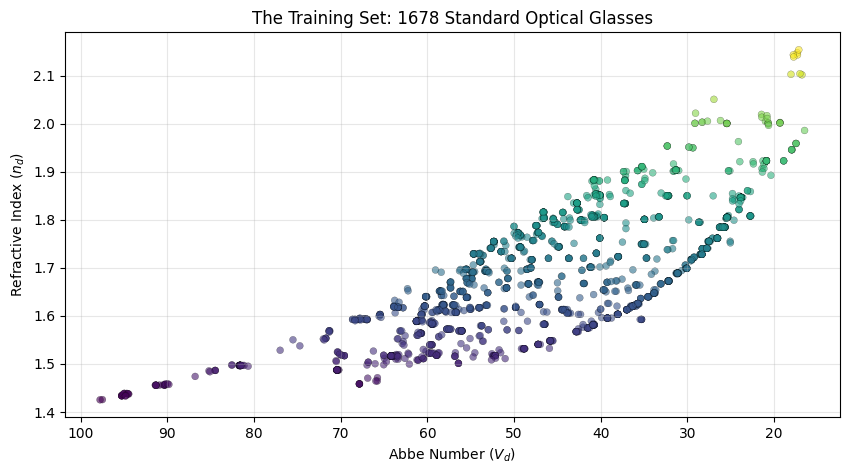

In [5]:
# Visualization: Glass diagram for dataset
plt.figure(figsize=(10, 5))
plt.scatter(
    df_glass['Vd'], 
    df_glass['nd'], 
    c=df_glass['nd'], 
    cmap='viridis', 
    s=25, 
    alpha=0.6, 
    edgecolors='k', 
    linewidth=0.2
)
plt.gca().invert_xaxis()
plt.title(f"The Training Set: {len(df_glass)} Standard Optical Glasses")
plt.xlabel("Abbe Number ($V_d$)")
plt.ylabel("Refractive Index ($n_d$)")
plt.grid(True, alpha=0.3)
plt.show()

## 2. Determining the Optimal Basis Function
To construct a model, we must first choose a mathematical basis function $f(\lambda)$. While polynomials ($A + B\lambda + C\lambda^2$) or Cauchy equations are common, they may not be the most efficient representation for typical glass dispersion.

We apply **Principal Component Analysis (PCA)** to the dataset to determine the effective dimensionality of the problem and identifying the optimal functional shape. We subtract the base refractive index ($n_d$) from each curve to isolate the dispersion shape.

### Hypothesis
The **Buchdahl dispersion model** utilizes a coordinate transformation $\omega$ designed to linearize the dispersion of silicate glasses:
$$\omega = \frac{\lambda - \lambda_0}{1 + 2.5(\lambda - \lambda_0)}$$
If this coordinate transformation is physically robust, the first principal component (PC1) of our data should strongly correlate with $\omega$.

In [6]:
# Constants
LAM_D = 0.5875618

def buchdahl_coordinate(lam):
    """
    Transforms wavelength to the normalized Buchdahl coordinate.
    """
    return (lam - LAM_D) / (1.0 + 2.5 * (lam - LAM_D))

In [7]:
# --- PCA Execution ---
# 1. Prepare Data Matrix
# Shape: (n_samples, n_wavelengths)
X_curves = np.vstack(df_glass['curve'].values)

# 2. Center the data per-sample
# We subtract nd to focus purely on the dispersion slope and curvature,
# removing the "piston" term (absolute index).
nd_vector = df_glass['nd'].values[:, np.newaxis]
X_dispersion = X_curves - nd_vector

# 3. Fit PCA
pca = PCA(n_components=3)  # choose 3 components
pca.fit(X_dispersion)

,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",3
,"copy copy: bool, default=TrueIf False, data passed to fit are overwritten and runningfit(X).transform(X) will not yield the expected results,use fit_transform(X) instead.",True
,"whiten whiten: bool, default=FalseWhen True (False by default) the `components_` vectors are multipliedby the square root of n_samples and then divided by the singular valuesto ensure uncorrelated outputs with unit component-wise variances.Whitening will remove some information from the transformed signal(the relative variance scales of the components) but can sometimeimprove the predictive accuracy of the downstream estimators bymaking their data respect some hard-wired assumptions.",False
,"svd_solver svd_solver: {'auto', 'full', 'covariance_eigh', 'arpack', 'randomized'}, default='auto'""auto"" : The solver is selected by a default 'auto' policy is based on `X.shape` and `n_components`: if the input data has fewer than 1000 features and more than 10 times as many samples, then the ""covariance_eigh"" solver is used. Otherwise, if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ""randomized"" method is selected. Otherwise the exact ""full"" SVD is computed and optionally truncated afterwards.""full"" : Run exact full SVD calling the standard LAPACK solver via `scipy.linalg.svd` and select the components by postprocessing""covariance_eigh"" : Precompute the covariance matrix (on centered data), run a classical eigenvalue decomposition on the covariance matrix typically using LAPACK and select the components by postprocessing. This solver is very efficient for n_samples >> n_features and small n_features. It is, however, not tractable otherwise for large n_features (large memory footprint required to materialize the covariance matrix). Also note that compared to the ""full"" solver, this solver effectively doubles the condition number and is therefore less numerical stable (e.g. on input data with a large range of singular values).""arpack"" : Run SVD truncated to `n_components` calling ARPACK solver via `scipy.sparse.linalg.svds`. It requires strictly `0 < n_components < min(X.shape)`""randomized"" : Run randomized SVD by the method of Halko et al... versionadded:: 0.18.0.. versionchanged:: 1.5 Added the 'covariance_eigh' solver.",'auto'
,"tol tol: float, default=0.0Tolerance for singular values computed by svd_solver == 'arpack'.Must be of range [0.0, infinity)... versionadded:: 0.18.0",0.0
,"iterated_power iterated_power: int or 'auto', default='auto'Number of iterations for the power method computed bysvd_solver == 'randomized'.Must be of range [0, infinity)... versionadded:: 0.18.0",'auto'
,"n_oversamples n_oversamples: int, default=10This parameter is only relevant when `svd_solver=""randomized""`.It corresponds to the additional number of random vectors to sample therange of `X` so as to ensure proper conditioning. See:func:`~sklearn.utils.extmath.randomized_svd` for more details... versionadded:: 1.1",10
,"power_iteration_normalizer power_iteration_normalizer: {'auto', 'QR', 'LU', 'none'}, default='auto'Power iteration normalizer for randomized SVD 

In [8]:
# Report Explained Variance
print("--- Effective Degrees of Freedom (Visible Spectrum) ---")
variance = pca.explained_variance_ratio_
print(f"PC1 (Primary Dispersion):   {variance[0]*100:.5f}%")
print(f"PC2 (Secondary Curvature):  {variance[1]*100:.5f}%")
print(f"PC3 (Residuals):            {variance[2]*100:.5f}%")
print(f"Total Explained (3 terms):  {np.sum(variance)*100:.6f}%")

--- Effective Degrees of Freedom (Visible Spectrum) ---
PC1 (Primary Dispersion):   99.91697%
PC2 (Secondary Curvature):  0.08068%
PC3 (Residuals):            0.00226%
Total Explained (3 terms):  99.999913%


As can be seen, 3 components alone account for >99.9999% of the variance in the refractive index data.

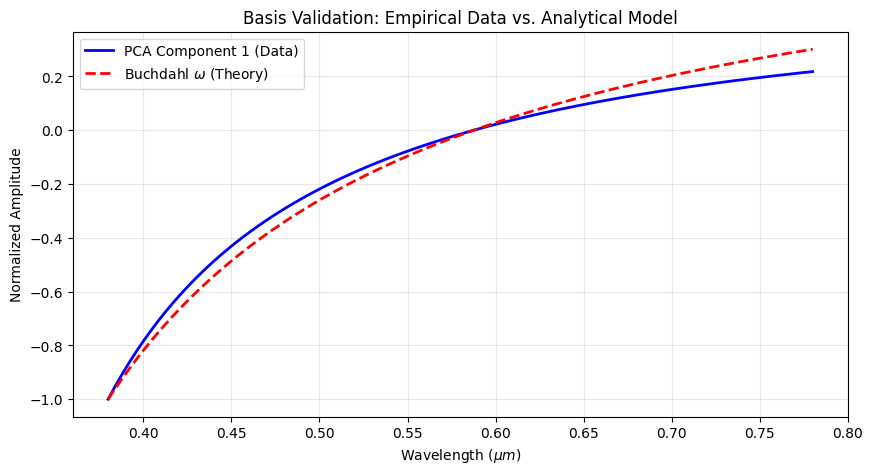

In [9]:
# --- Visualization: Buchdahl vs. Data ---
w_vec = buchdahl_coordinate(WAVE_GRID)

# Align signs for visual comparison (PCA sign is arbitrary)
pc1 = pca.components_[0]
if np.corrcoef(pc1, w_vec)[0, 1] < 0:
    pc1 = -pc1

# Normalize for plotting shape comparison
pc1_norm = pc1 / np.max(np.abs(pc1))
w_vec_norm = w_vec / np.max(np.abs(w_vec))

plt.figure(figsize=(10, 5))
plt.plot(WAVE_GRID, pc1_norm, 'b-', linewidth=2, label='PCA Component 1 (Data)')
plt.plot(WAVE_GRID, w_vec_norm, 'r--', linewidth=2, label=r'Buchdahl $\omega$ (Theory)')
plt.title("Basis Validation: Empirical Data vs. Analytical Model")
plt.xlabel(r"Wavelength ($\mu m$)")
plt.ylabel("Normalized Amplitude")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. Analyzing the Coefficients
Having validated that the Buchdahl coordinate is a suitable proxy for the primary dispersion vector, we adopt the 3-term Buchdahl model:
$$n(\omega) = n_d + v_1 \omega + v_2 \omega^2 + v_3 \omega^3$$

We fit this equation to every glass in the dataset to extract the "True" coefficients. This allows us to inspect how these coefficients relate to the input parameters ($n_d, V_d$).

### The "Partial Dispersion" Problem
Standard 2-parameter models typically assume:
1.  $v_1$ is linear with $1/V_d$.
2.  $v_2$ is linear with $1/V_d$.
3.  $v_3$ is zero.

We visualize the calculated $v_3$ term on the Abbe diagram. A non-random pattern would indicate that $v_3$ is not noise, but a systematic property of the glass chemistry that we can predict.

In [10]:
def buchdahl_3term(w, v1, v2, v3, nd_fixed):
    """
    3-term Buchdahl model with fixed intercept.
    """
    return nd_fixed + v1 * w + v2 * (w**2) + v3 * (w**3)

In [11]:
# --- Extract Coefficients ---
results = []
w_grid_calc = buchdahl_coordinate(WAVE_GRID)

print("Extracting coefficients for all glasses...")

for idx, row in df_glass.iterrows():
    # Define objective function for this specific glass
    nd_glass = row['nd']
    
    def objective(w, v1, v2, v3):
        return buchdahl_3term(w, v1, v2, v3, nd_glass)
    
    try:
        # Initial guess [0,0,0] is important for convergence stability
        popt, _ = curve_fit(objective, w_grid_calc, row['curve'], p0=[0, 0, 0])
        
        results.append({
            'nd': row['nd'],
            'Vd': row['Vd'],
            'v1': popt[0],
            'v2': popt[1],
            'v3': popt[2]
        })
    except Exception:
        continue

df_coeffs = pd.DataFrame(results)

Extracting coefficients for all glasses...


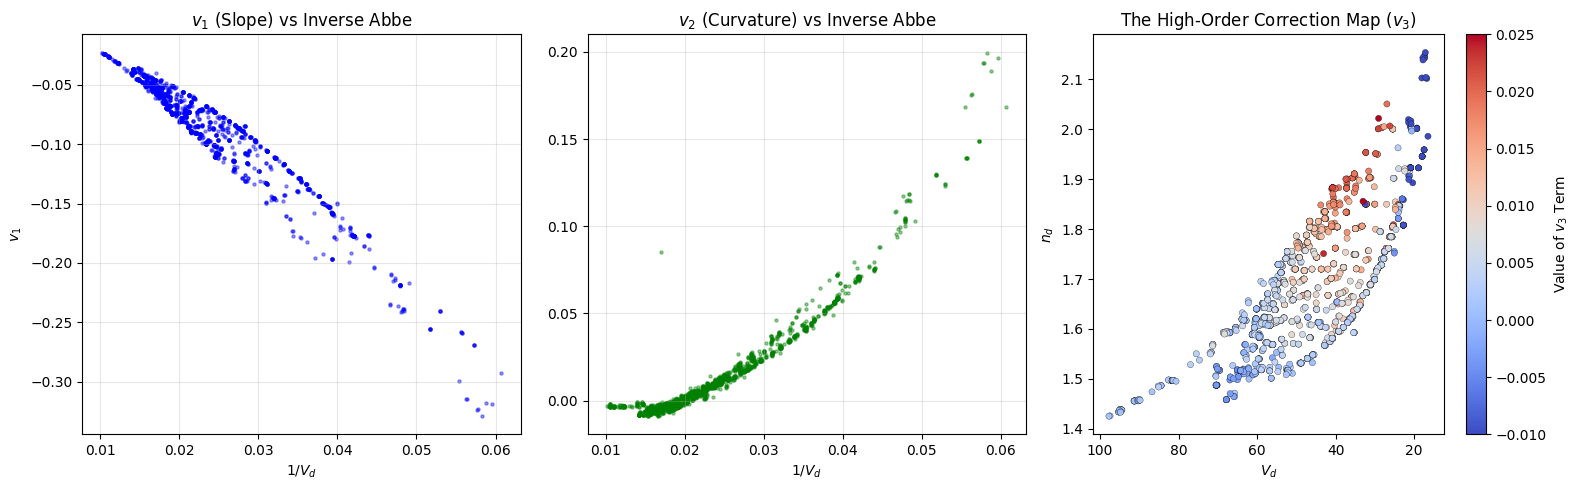

In [12]:
# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: v1 vs 1/Vd (Check Linearity)
axes[0].scatter(1.0/df_coeffs['Vd'], df_coeffs['v1'], s=5, alpha=0.4, c='blue')
axes[0].set_title("$v_1$ (Slope) vs Inverse Abbe")
axes[0].set_xlabel("$1/V_d$")
axes[0].set_ylabel("$v_1$")
axes[0].grid(True, alpha=0.3)

# Plot 2: v2 vs 1/Vd (Check Curvature)
axes[1].scatter(1.0/df_coeffs['Vd'], df_coeffs['v2'], s=5, alpha=0.4, c='green')
axes[1].set_title("$v_2$ (Curvature) vs Inverse Abbe")
axes[1].set_xlabel("$1/V_d$")
axes[1].grid(True, alpha=0.3)

# Plot 3: v3 Map (Check for Structure)
# We plot v3 color-coded on the Glass Map
sc = axes[2].scatter(
    df_coeffs['Vd'], 
    df_coeffs['nd'], 
    c=df_coeffs['v3'], 
    cmap='coolwarm', 
    s=20, 
    edgecolors='k', 
    linewidth=0.2,
    vmin=-0.010, vmax=0.025
)
cbar = plt.colorbar(sc, ax=axes[2])
cbar.set_label("Value of $v_3$ Term")
axes[2].invert_xaxis()
axes[2].set_title("The High-Order Correction Map ($v_3$)")
axes[2].set_xlabel("$V_d$")
axes[2].set_ylabel("$n_d$")

plt.tight_layout()
plt.show()

## 4. Model Discovery via LASSO Regression
The visualization above reveals that $v_3$ is non-zero and structured. Additionally, $v_2$ exhibits a slight parabolic relationship with $1/V_d$.

To capture these behaviors without overfitting, we employ **LASSO Regression** (Least Absolute Shrinkage and Selection Operator). We construct a feature matrix containing potential physical terms (e.g., $1/V_d^2$, $n_d/V_d$) and allow LASSO to select only the terms that provide a statistically significant improvement to the fit.

This results in a sparse set of equations that relate the inputs ($n_d, V_d$) to the Buchdahl coefficients.

In [13]:
# --- Feature Engineering ---
# Construct candidate features based on physical intuition
df_train = df_coeffs.dropna().copy()
X = pd.DataFrame()

# Basic Dispersion Terms
X['inv_V'] = 1.0 / df_train['Vd']
X['inv_V2'] = (1.0 / df_train['Vd']) ** 2

# Index Interaction Terms (suggested by the v3 map structure)
X['nd'] = df_train['nd']
X['nd_sq'] = df_train['nd'] ** 2
X['nd_div_V'] = df_train['nd'] / df_train['Vd']

In [14]:
discovered_equations = {}

print("--- LASSO Model Discovery ---")

targets = ['v1', 'v2', 'v3']

for target in targets:
    y = df_train[target].values
    
    # 1. Feature Selection via LASSO (BIC criterion)
    # We use a pipeline with StandardScaler to ensure fair regularization
    model = make_pipeline(StandardScaler(), LassoLarsIC(criterion='bic', max_iter=5000))
    model.fit(X, y)
    
    # Identify selected features
    lasso = model.named_steps['lassolarsic']
    active_mask = lasso.coef_ != 0
    selected_features = X.columns[active_mask].tolist()
    
    # 2. Final Fit (OLS)
    # We refit using simple Linear Regression on only the selected features
    # to obtain un-regularized physical coefficients.
    final_model = LinearRegression()
    final_model.fit(X[selected_features], y)
    score = final_model.score(X[selected_features], y)
    
    # Store results
    discovered_equations[target] = {
        'intercept': final_model.intercept_,
        'coeffs': dict(zip(selected_features, final_model.coef_))
    }
    
    # Display Result
    print(f"\nTarget: {target} (R^2 = {score:.4f})")
    print(f"Intercept: {final_model.intercept_:.6f}")
    for name, val in zip(selected_features, final_model.coef_):
        print(f" + {val:.6f} * ({name})")

--- LASSO Model Discovery ---

Target: v1 (R^2 = 1.0000)
Intercept: 0.004160
 + 4.462559 * (inv_V)
 + 2.326660 * (inv_V2)
 + 0.002330 * (nd)
 + -0.003697 * (nd_sq)
 + -4.697604 * (nd_div_V)

Target: v2 (R^2 = 0.9896)
Intercept: 0.066434
 + -7.636396 * (inv_V)
 + 12.597434 * (inv_V2)
 + -0.037014 * (nd_sq)
 + 5.551013 * (nd_div_V)

Target: v3 (R^2 = 0.5213)
Intercept: -0.032218
 + 2.230357 * (inv_V)
 + -103.318994 * (inv_V2)
 + -0.009654 * (nd_sq)
 + 1.934983 * (nd_div_V)


## 5. Model Validation and Error Analysis

To quantify the predictive fidelity of our derived model, we evaluate the reconstruction error across the full dataset of standard optical glasses.

**Methodology:**
We test the model's **generative capacity** by reconstructing the refractive index of each glass in the catalog using *only* its $n_d$ and $V_d$ parameters. This simulates the real-world usage of the data-based model implementation.
1.  **Input:** Extract $n_d$ and $V_d$ for every glass.
2.  **Prediction:** Calculate the Buchdahl coefficients ($v_1, v_2, v_3$) using the regression weights derived in Section 4.
3.  **Reconstruction:** Generate the full spectral curve $n(\lambda)$.
4.  **Validation:** Compare against the reference catalog measurements.

**Metric:**
We track the **Root Mean Square Error (RMSE)**:

$$RMSE = \sqrt{\frac{1}{N_\lambda} \sum (n_{pred}(\lambda) - n_{measured}(\lambda))^2}$$

We compare this against a **Baseline Linear Model**, which assumes a simple linear dispersion slope between the F and C lines.

In [15]:
# --- 1. Helper Function: The Optimized Model Logic ---
def predict_abbe_index(nd, Vd, wave_grid):
    """
    Reconstructs the refractive index curve using the LASSO-derived coefficients 
    from Section 4. This replicates the logic that will go into the new AbbeMaterial class.
    """
    # Buchdahl Constants
    WAVE_D = 0.5875618
    ALPHA = 2.5
    
    # Feature Engineering (Must match the regression input exactly)
    inv_V = 1.0 / Vd
    inv_V2 = 1.0 / (Vd**2)
    nd_sq = nd**2
    nd_div_V = nd / Vd
    
    # --- COEFFICIENTS FROM SECTION 4 LASSO ANALYSIS ---
    
    # Target: v1
    v1 = (0.004160 
          + 4.462559 * inv_V 
          + 2.326660 * inv_V2 
          + 0.002330 * nd 
          - 0.003697 * nd_sq 
          - 4.697604 * nd_div_V)
          
    # Target: v2
    v2 = (0.066434 
          - 7.636396 * inv_V 
          + 12.597434 * inv_V2 
          - 0.037014 * nd_sq 
          + 5.551013 * nd_div_V)
          
    # Target: v3
    v3 = (-0.032218 
          + 2.230357 * inv_V 
          - 103.318994 * inv_V2 
          - 0.009654 * nd_sq 
          + 1.934983 * nd_div_V)
    
    # --- Spectral Reconstruction ---
    # Calculate Buchdahl Coordinate omega
    omega = (wave_grid - WAVE_D) / (1 + ALPHA * (wave_grid - WAVE_D))
    
    # Buchdahl Polynomial: n = nd + sum(vi * omega^i)
    n_pred = nd + v1 * omega + v2 * (omega**2) + v3 * (omega**3)
    
    return n_pred

# --- 2. Validation Loop ---
rmse_baseline = []
rmse_prediction = []
max_errors = []

print(f"Validating model against {len(df_glass)} catalog glasses...")

for idx, row in df_glass.iterrows():
    # Ground Truth
    n_real = row['curve']
    
    # Baseline Model (Linear Assumption)
    # Slope defined by F and C lines (Normal Line assumption)
    slope = (row['nd'] - 1) / (row['Vd'] * (WAVE_F - WAVE_C))
    n_baseline = row['nd'] + slope * (WAVE_GRID - WAVE_D)
    
    # Optimized Model Prediction
    n_pred = predict_abbe_index(row['nd'], row['Vd'], WAVE_GRID)

    # Compute Errors
    error_base = np.sqrt(np.mean((n_baseline - n_real)**2))
    error_pred = np.sqrt(np.mean((n_pred - n_real)**2))
    
    rmse_baseline.append(error_base)
    rmse_prediction.append(error_pred)
    
    # Track worst-case spectral error
    max_errors.append(np.max(np.abs(n_pred - n_real)))

# Convert to arrays
rmse_baseline = np.array(rmse_baseline)
rmse_prediction = np.array(rmse_prediction)
max_errors = np.array(max_errors)

print("Validation Loop Complete.")

Validating model against 1678 catalog glasses...
Validation Loop Complete.


In [16]:
# Compute Aggregate Statistics
mean_rmse_base = np.mean(rmse_baseline)
mean_rmse_pred = np.mean(rmse_prediction)
improvement_factor = mean_rmse_base / mean_rmse_pred

print("-" * 65)
print(f"GLOBAL VALIDATION STATISTICS (N={len(rmse_prediction)})")
print("-" * 65)
print(f"Baseline (Linear) Mean RMSE:    {mean_rmse_base:.2e}")
print(f"Optimized Model Mean RMSE:      {mean_rmse_pred:.2e}")
print(f"IMPROVEMENT FACTOR:             {improvement_factor:.1f}x reduction in error")
print("-" * 65)
print(f"Avg Max Spectral Error:         {np.mean(max_errors):.2e}")
print("-" * 65)

-----------------------------------------------------------------
GLOBAL VALIDATION STATISTICS (N=1678)
-----------------------------------------------------------------
Baseline (Linear) Mean RMSE:    5.94e-03
Optimized Model Mean RMSE:      6.84e-05
IMPROVEMENT FACTOR:             86.9x reduction in error
-----------------------------------------------------------------
Avg Max Spectral Error:         2.85e-04
-----------------------------------------------------------------


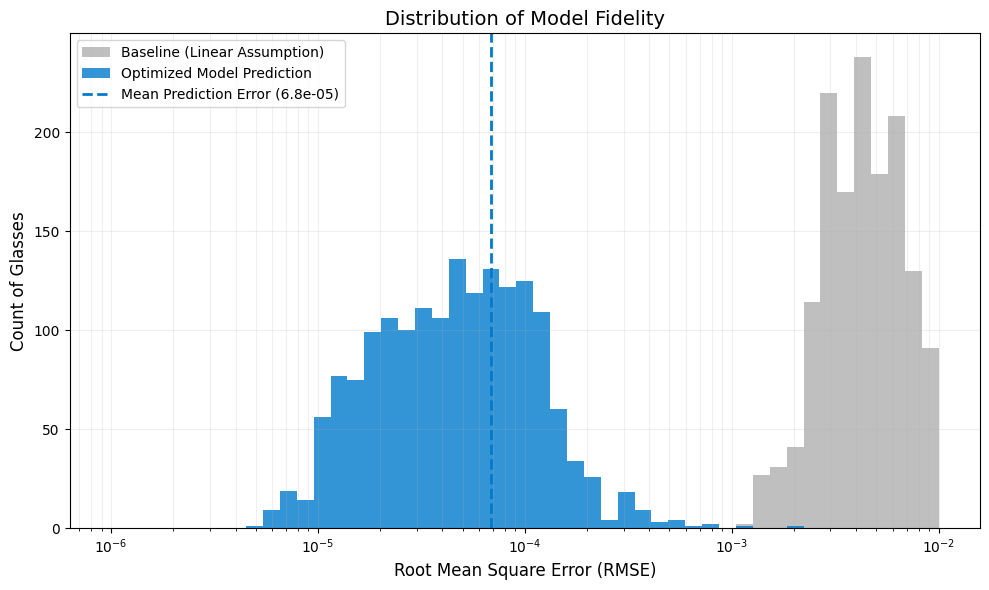

In [17]:
plt.figure(figsize=(10, 6))

# Log-spaced bins for wide dynamic range
bins = np.logspace(np.log10(1e-6), np.log10(1e-2), 50)

plt.hist(rmse_baseline, bins=bins, alpha=0.5, color='gray', label='Baseline (Linear Assumption)')
plt.hist(rmse_prediction, bins=bins, alpha=0.8, color='#007acc', label='Optimized Model Prediction')

# Mean Markers
plt.axvline(mean_rmse_pred, color='#007acc', linestyle='--', linewidth=2, label=f'Mean Prediction Error ({mean_rmse_pred:.1e})')

plt.xscale('log')
plt.xlabel('Root Mean Square Error (RMSE)', fontsize=12)
plt.ylabel('Count of Glasses', fontsize=12)
plt.title('Distribution of Model Fidelity', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.show()

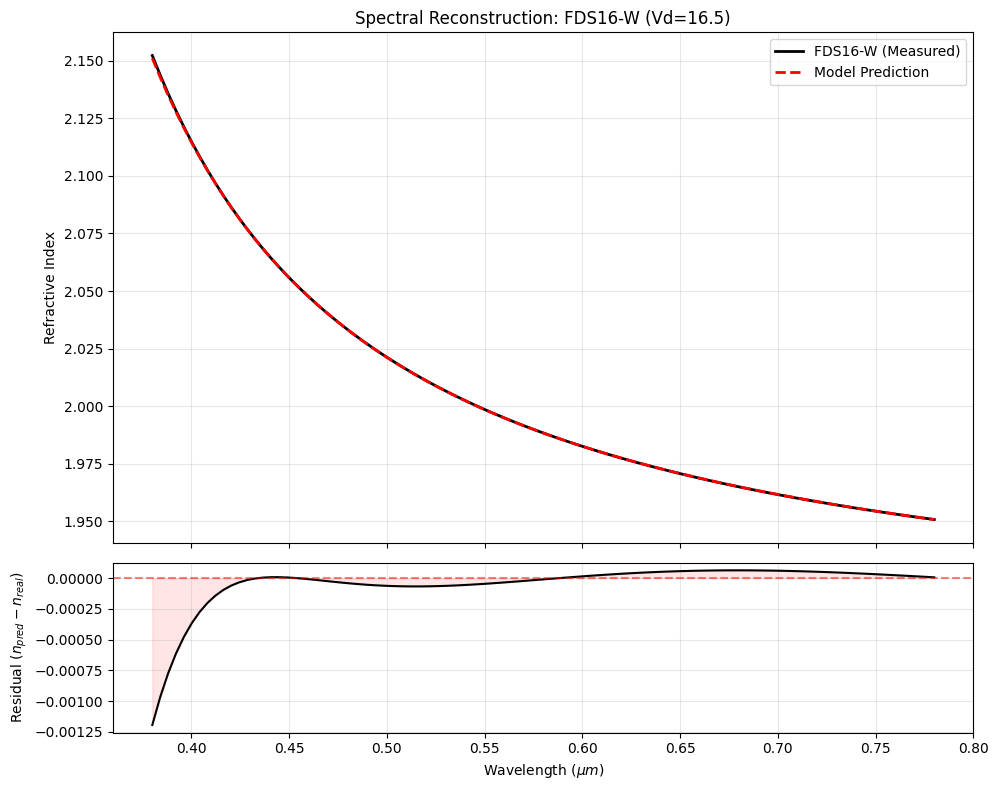

In [18]:
# Select a stress-test glass (Low Abbe number = High Dispersion)
sample_idx = df_glass['Vd'].idxmin() 
sample = df_glass.iloc[sample_idx]

# 1. Get Ground Truth
n_real_sample = sample['curve']

# 2. Generate Prediction
n_pred_sample = predict_abbe_index(sample['nd'], sample['Vd'], WAVE_GRID)

# 3. Calculate Residual
residual = n_pred_sample - n_real_sample

# 4. Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Top: Absolute Index
ax1.plot(WAVE_GRID, n_real_sample, 'k-', linewidth=2, label=f"{sample['name']} (Measured)")
ax1.plot(WAVE_GRID, n_pred_sample, 'r--', linewidth=2, label='Model Prediction')
ax1.set_ylabel('Refractive Index')
ax1.set_title(f"Spectral Reconstruction: {sample['name']} (Vd={sample['Vd']:.1f})")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom: Residual
ax2.plot(WAVE_GRID, residual, 'k-')
ax2.fill_between(WAVE_GRID, residual, 0, color='red', alpha=0.1)

ax2.axhline(0, color='r', linestyle='--', alpha=0.5)

ax2.set_ylabel('Residual ($n_{pred} - n_{real}$)')
ax2.set_xlabel(r'Wavelength ($\mu m$)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Production Implementation
We now implement the final `OptimizedAbbeMaterial` class. This class incorporates the specific LASSO-derived coefficients found in the discovery phase.

**Key Features:**
* **Hardcoded Physics:** The regression weights are baked into the class.
* **Buchdahl Engine:** Uses the robust coordinate transformation $\omega$ for spectral stability.
* **Vectorized:** Built on the Optiland backend to support efficient array operations during ray tracing.

The code below defines the class and demonstrates its usage by comparing the "Model N-SF11" (generated purely from $n_d=1.785, V_d=25.7$) against the actual measured data for N-SF11.

In [19]:
import optiland.backend as be
from optiland.materials.base import BaseMaterial
from optiland.materials import Material

class OptimizedAbbeMaterial(BaseMaterial):
    """
    A High-Accuracy Data-Driven Model Glass.

    Predicts the full dispersion curve from only n_d and V_d using a
    statistical prior derived from catalog glass data.

    Attributes:
        index (float): Refractive index at d-line (587.56 nm)
        abbe (float): Abbe number (Vd)
    """

    def __init__(self, n, abbe):
        super().__init__()
        self.index = be.array([n])
        self.abbe = be.array([abbe])
        self._coeffs = self._predict_coefficients()

    def _predict_coefficients(self):
        """
        Calculates Buchdahl coefficients (v1, v2, v3) using the
        equations found via LASSO regression.
        """
        # 1. Feature Engineering
        inv_V = 1.0 / self.abbe
        inv_V2 = inv_V ** 2
        nd = self.index
        nd_sq = nd ** 2
        nd_div_V = nd * inv_V

        # 2. The Discovered Physics Equations
        
        # Target: v1 (Primary Slope)
        v1 = (0.004160 
              + 4.462559 * inv_V 
              + 2.326660 * inv_V2 
              + 0.002330 * nd 
              - 0.003697 * nd_sq 
              - 4.697604 * nd_div_V)

        # Target: v2 (Curvature)
        v2 = (0.066434 
              - 7.636396 * inv_V 
              + 12.597434 * inv_V2 
              - 0.037014 * nd_sq 
              + 5.551013 * nd_div_V)

        # Target: v3 (Deep Blue Correction)
        v3 = (-0.032218 
              + 2.230357 * inv_V 
              - 103.318994 * inv_V2 
              - 0.009654 * nd_sq 
              + 1.934983 * nd_div_V)

        return v1, v2, v3

    def _calculate_n(self, wavelength, **kwargs):
        wavelength = be.array(wavelength)
        
        # Buchdahl Coordinate Transformation (d-line centered)
        # w = (lam - 0.58756) / (1 + 2.5 * (lam - 0.58756))
        lam_norm = wavelength - 0.5875618
        w = lam_norm / (1.0 + 2.5 * lam_norm)
        
        v1, v2, v3 = self._coeffs
        
        # n(w) = nd + v1*w + v2*w^2 + v3*w^3
        return self.index + v1 * w + v2 * (w**2) + v3 * (w**3)

    def _calculate_k(self, wavelength, **kwargs):
        return be.zeros_like(wavelength)
    
    def to_dict(self):
        material_dict = super().to_dict()
        material_dict.update({"index": float(self.index), "abbe": float(self.abbe)})
        return material_dict

Demonstration: Modeling N-SF11
Inputs: nd=1.7847, Vd=25.68


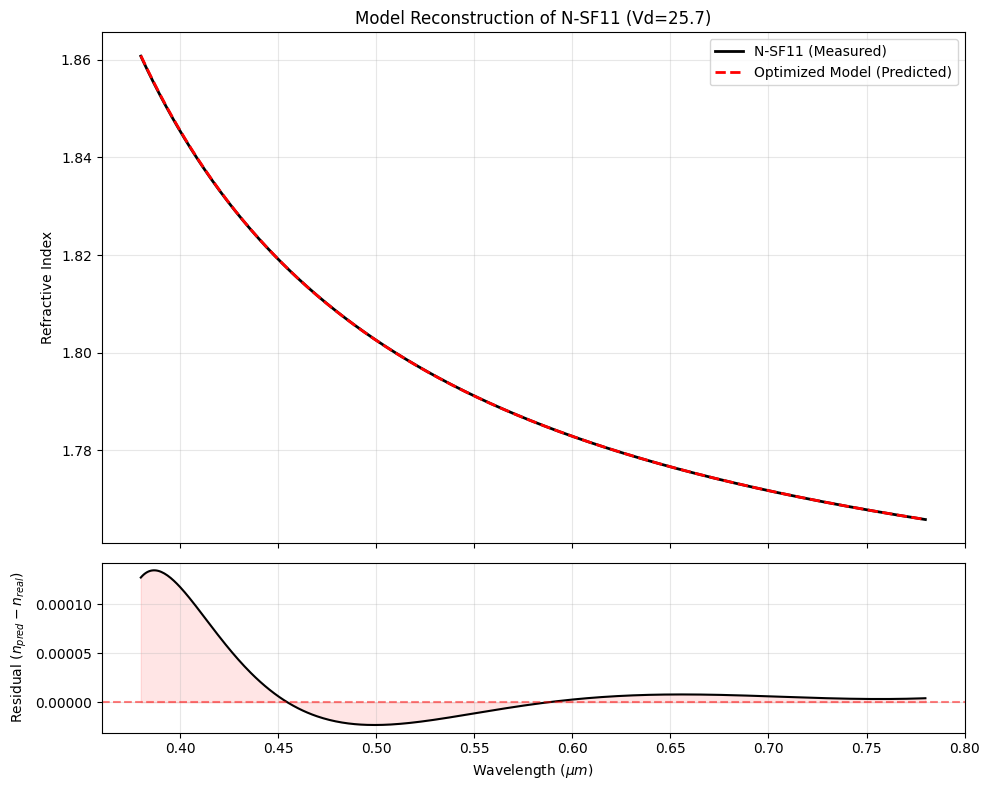

In [ ]:
# We verify the model against a difficult high-index flint (N-SF11)
glass_name = "N-SF11"
real_glass = Material(glass_name)

# 1. Create the Model Glass using ONLY nd and Vd
nd_val = real_glass.n(0.5875618).item()
Vd_val = real_glass.abbe().item()
model_glass = OptimizedAbbeMaterial(nd_val, Vd_val)

print(f"Demonstration: Modeling {glass_name}")
print(f"Inputs: nd={nd_val:.4f}, Vd={Vd_val:.2f}")

# 2. Calculate Curves
wave_grid = np.linspace(0.38, 0.78, 500)
n_real = real_glass.n(wave_grid)
n_model = model_glass.n(wave_grid)
residual = n_model - n_real

# 3. Visualize
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Top: Absolute Index
ax1.plot(wave_grid, n_real, 'k-', linewidth=2, label=f'{glass_name} (Measured)')
ax1.plot(wave_grid, n_model, 'r--', linewidth=2, label='Optimized Model (Predicted)')
ax1.set_ylabel('Refractive Index')
ax1.set_title(f'Model Reconstruction of {glass_name} (Vd={Vd_val:.1f})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom: Residual Error
ax2.plot(wave_grid, residual, 'k-')
ax2.fill_between(wave_grid, residual, 0, color='red', alpha=0.1)

ax2.axhline(0, color='r', linestyle='--', alpha=0.5)

ax2.set_ylabel('Residual ($n_{pred} - n_{real}$)')
ax2.set_xlabel(r'Wavelength ($\mu m$)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Conclusions

This notebook has successfully derived and validated the **AbbeMaterial** implementation for Optiland. By applying data science techniques to the physics of optical dispersion, we have moved beyond traditional heuristic models.

## Key Results

**Sparse Representation:** The LassoLarsIC analysis demonstrated that the full spectral behavior of standard glasses can be accurately reconstructed using a sparse subset of Buchdahl terms.

**Basis Validity:** The PCA decomposition confirms that the refractive index curves of glasses in this study lie on a low-dimensional manifold. This justifies the use of a constrained model (the optimized Buchdahl form) rather than a free-form interpolation.

## Justification of Approach
We utilize a data-driven optimization of the **Buchdahl Dispersion Model** rather than direct polynomial interpolation (e.g., solving for Sellmeier coefficients) for two primary reasons:

1.  **Numerical Stability (Convexity):**
    solving for polynomial coefficients (like Sellmeier $B_i, C_i$) from limited data points is a non-convex problem. Small changes in inputs ($n_d, V_d$) can result in large, chaotic jumps in coefficients, leading to singularities. The Buchdahl coordinate $\omega$, by contrast, orthogonalizes the spectral space, ensuring that the mapping from ($n_d, V_d$) to the dispersion curve remains smooth and continuous.

2.  **Parsimony (Occam's Razor):**
    By using Lasso regression, we strictly enforce sparsity. The model includes only the dispersion terms necessary to describe the variance in the training data, discarding higher-order terms that contribute to overfitting (ringing) at the spectral edges. This ensures the `AbbeMaterial` behaves predictably even when simulating glasses outside the standard catalog range.